In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(101)

In [2]:
import tensorflow as tf
tf.__version__
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


In [3]:
data = pd.read_csv('input/skin_cancer_mnist/HAM10000_metadata.csv')
data['image_full_name']=data['image_id']+'.jpg'
X=data[['image_full_name','dx','lesion_id']]
X.head(5)

,image_full_name,dx,lesion_id
0,ISIC_0027419.jpg,bkl,HAM_0000118
1,ISIC_0025030.jpg,bkl,HAM_0000118
2,ISIC_0026769.jpg,bkl,HAM_0002730
3,ISIC_0025661.jpg,bkl,HAM_0002730
4,ISIC_0031633.jpg,bkl,HAM_0001466


In [4]:
from sklearn.model_selection import train_test_split
Y=X.pop('dx').to_frame()
X_train,X_test,y_train,y_test = train_test_split(X,Y,random_state=101,test_size=0.2)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,random_state=101,test_size=0.2)

In [5]:
train=pd.concat([X_train,y_train],axis=1)
val=pd.concat([X_val,y_val],axis=1)
test=pd.concat([X_test,y_test],axis=1)
train,val,test

(       image_full_name    lesion_id   dx
 2178  ISIC_0029893.jpg  HAM_0006699  mel
 3919  ISIC_0024744.jpg  HAM_0004434   nv
 5121  ISIC_0024993.jpg  HAM_0000147   nv
 5013  ISIC_0032224.jpg  HAM_0005033   nv
 2506  ISIC_0031749.jpg  HAM_0002791  bcc
 ...                ...          ...  ...
 1166  ISIC_0033256.jpg  HAM_0005584   df
 6141  ISIC_0024605.jpg  HAM_0001045   nv
 7125  ISIC_0033686.jpg  HAM_0002494   nv
 8912  ISIC_0030740.jpg  HAM_0002319   nv
 7244  ISIC_0027432.jpg  HAM_0007196   nv
 
 [6409 rows x 3 columns],
        image_full_name    lesion_id   dx
 5659  ISIC_0027532.jpg  HAM_0005602   nv
 2539  ISIC_0026593.jpg  HAM_0004970  bcc
 5221  ISIC_0026078.jpg  HAM_0005108   nv
 6392  ISIC_0028654.jpg  HAM_0002179   nv
 4580  ISIC_0029758.jpg  HAM_0004314   nv
 ...                ...          ...  ...
 3035  ISIC_0031068.jpg  HAM_0003396   nv
 435   ISIC_0026606.jpg  HAM_0006123  bkl
 2130  ISIC_0024313.jpg  HAM_0002869  mel
 1736  ISIC_0025531.jpg  HAM_0004767  mel
 8742 

In [6]:
from sklearn.preprocessing import LabelEncoder
encoder= LabelEncoder()
encoder.fit(val['dx'])
name_as_indexes_train=encoder.transform(val['dx']) 
val['label']=name_as_indexes_train

In [7]:
encoder=LabelEncoder()
encoder.fit(test['dx'])
name_as_indexes_test=encoder.transform(test['dx']) 
test['label']=name_as_indexes_test

In [42]:
# Import Images into train, test and val datasets

In [8]:
from keras.preprocessing.image import ImageDataGenerator

data_dir = 'input/all_images/'
batch_size = 32
size=32

train_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range=10,  
                                     zoom_range = 0.1, 
                                     width_shift_range=0.0,  height_shift_range=0.00) 



In [9]:
train_data = train_generator.flow_from_dataframe(dataframe=train,x_col="image_full_name",y_col="dx",
                                                batch_size=32,directory=data_dir,
                                                shuffle=True,class_mode="categorical",target_size=(size,size))

Found 6409 validated image filenames belonging to 7 classes.


In [10]:
test_generator=ImageDataGenerator(rescale = 1./255,rotation_range=10,  
                                     zoom_range = 0.1, 
                                     width_shift_range=0.0,  height_shift_range=0.02)

In [11]:
test_generator=ImageDataGenerator(rescale = 1./255,rotation_range=10,  
                                     zoom_range = 0.1, 
                                     width_shift_range=0.0,  height_shift_range=0.02)
test_data = test_generator.flow_from_dataframe(dataframe=test,x_col="image_full_name",y_col="dx",
                                                batch_size=32,directory=data_dir,
                                                shuffle=False,class_mode="categorical",target_size=(size,size))
class_names = list(test_data.class_indices)
num_classes = len(class_names)

Found 2003 validated image filenames belonging to 7 classes.


In [12]:
val_data = test_generator.flow_from_dataframe(dataframe=val,x_col="image_full_name",y_col="dx",
                                                batch_size=32,directory=data_dir,
                                                shuffle=False,class_mode="categorical",target_size=(size,size))

Found 1603 validated image filenames belonging to 7 classes.


# Model Generation

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [68]:
model = Sequential([
    Conv2D(64,3, activation='relu',input_shape = (size,size,3)),
    MaxPool2D(),
    
    Conv2D(128,3, activation='relu'),
    MaxPool2D(),

    Conv2D(256,3, activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),
    Dense(32),
    Dropout(0.3),
    Dense(7,activation='softmax')
])

model.summary()

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['acc'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 15, 15, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 6, 6, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 4, 4, 256)         295168    
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 2, 2, 256)       

c:\Users\nyila\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [69]:
epochs = 25

history = model.fit_generator(generator=train_data,
                    steps_per_epoch=train_data.samples//train_data.batch_size,
                    validation_data=val_data,
                    verbose=1,
                    validation_steps=val_data.samples//val_data.batch_size,
                    epochs=epochs)

C:\Users\nyila\AppData\Local\Temp\ipykernel_8376\3417632695.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_data,


Epoch 1/25
200/200 [==============================] - 46s 231ms/step - loss: 1.0607 - acc: 0.6665 - val_loss: 0.9300 - val_acc: 0.6756
Epoch 2/25
200/200 [==============================] - 43s 215ms/step - loss: 0.9394 - acc: 0.6652 - val_loss: 0.8983 - val_acc: 0.6756
Epoch 3/25
200/200 [==============================] - 43s 216ms/step - loss: 0.9159 - acc: 0.6788 - val_loss: 0.8811 - val_acc: 0.6750
Epoch 4/25
200/200 [==============================] - 43s 215ms/step - loss: 0.8923 - acc: 0.6821 - val_loss: 0.8798 - val_acc: 0.7075
Epoch 5/25
200/200 [==============================] - 43s 215ms/step - loss: 0.8597 - acc: 0.6917 - val_loss: 0.8407 - val_acc: 0.6906
Epoch 6/25
200/200 [==============================] - 43s 216ms/step - loss: 0.8239 - acc: 0.7011 - val_loss: 0.8212 - val_acc: 0.6981
Epoch 7/25
200/200 [==============================] - 43s 216ms/step - loss: 0.8194 - acc: 0.7064 - val_loss: 0.7942 - val_acc: 0.7088
Epoch 8/25
200/200 [==============================] - 4

In [14]:
def plot_histories(history,epochs):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

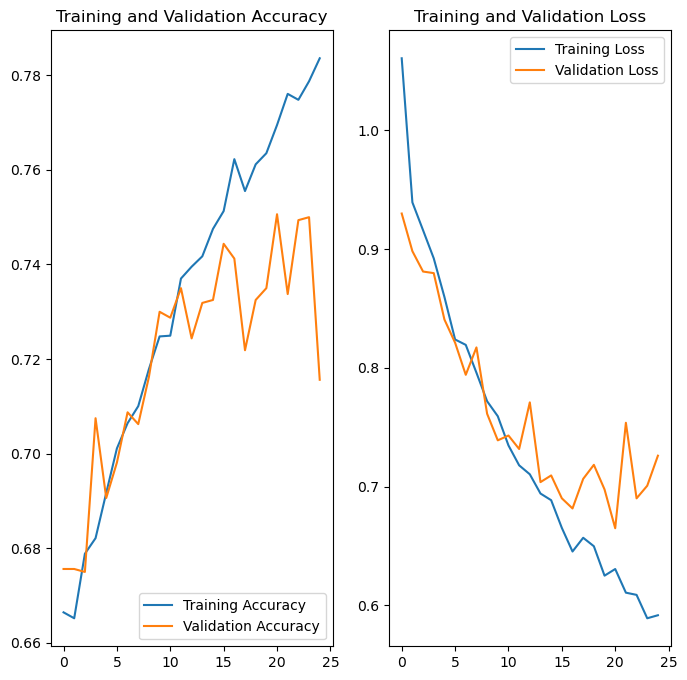

In [71]:
plot_histories(history,epochs)

In [33]:
from itertools import cycle
from sklearn.metrics import roc_curve,auc

from sklearn.preprocessing import label_binarize

class_names = list(test_data.class_indices)
num_classes = len(class_names)

y = label_binarize(name_as_indexes_test,
                        classes=[0, 1, 2,3,4,5,6])
y[:5]

def make_roc_curve(preds):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    lw=2
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], preds[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    colors = cycle(['blue', 'red', 'green'])
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label='{0} (area = {1:0.2f})'
                ''.format(class_names[i], roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Graph')
    plt.legend(loc="lower right")
    plt.show()

In [72]:
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

preds = model.predict(test_data,steps = test_data.samples/test_data.batch_size)
y_pred = preds.argmax(axis=1)


62/62 [==============================] - 40s 641ms/step


In [73]:
c=np.where(y_pred == name_as_indexes_test)
np.count_nonzero(c)
print("Test Accuracy :",(np.count_nonzero(c)/len(name_as_indexes_test))*100)

Test Accuracy : 73.83924113829256


In [75]:
report = classification_report(name_as_indexes_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.31      0.28      0.29        53
           1       0.46      0.42      0.44       109
           2       0.44      0.53      0.48       218
           3       0.00      0.00      0.00        20
           4       0.50      0.47      0.49       242
           5       0.87      0.88      0.88      1336
           6       0.75      0.60      0.67        25

    accuracy                           0.74      2003
   macro avg       0.48      0.45      0.46      2003
weighted avg       0.73      0.74      0.74      2003



c:\Users\nyila\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nyila\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nyila\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


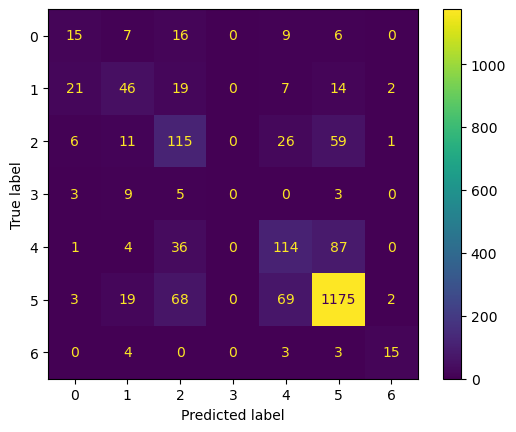

In [77]:
cm = confusion_matrix(name_as_indexes_test,y_pred)
ConfusionMatrixDisplay(cm).plot()

# best model so far

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

data_dir = 'input/all_images/'
batch_size = 32
size=32

train_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range=10,  
                                     zoom_range = 0.1,   
                                     horizontal_flip=True,
                                     shear_range=0.1) 

train_data = train_generator.flow_from_dataframe(dataframe=train,x_col="image_full_name",y_col="dx",
                                                batch_size=32,directory=data_dir,
                                                shuffle=True,class_mode="categorical",target_size=(size,size))

test_generator=ImageDataGenerator(rescale = 1./255)

test_data = test_generator.flow_from_dataframe(dataframe=test,x_col="image_full_name",y_col="dx",
                                                batch_size=32,directory=data_dir,
                                                shuffle=False,class_mode="categorical",target_size=(size,size))

val_data = test_generator.flow_from_dataframe(dataframe=val,x_col="image_full_name",y_col="dx",
                                                batch_size=32,directory=data_dir,
                                                shuffle=False,class_mode="categorical",target_size=(size,size))

In [123]:
model_1 = Sequential([
    Conv2D(256,3, activation='relu',input_shape = (size,size,3)),
    MaxPool2D(),
    
    Conv2D(128,3, activation='relu'),
    MaxPool2D(),

    Conv2D(64,3, activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),
    Dense(32),
    Dropout(0.3),
    Dense(7,activation='softmax')
])

model_1.summary()

model_1.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['acc'])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 15, 15, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 13, 13, 128)       295040    
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 6, 6, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 4, 4, 64)          73792     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 2, 2, 64)        

c:\Users\nyila\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [125]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

epochs = 50

history_1 = model_1.fit_generator(generator=train_data,
                    steps_per_epoch=train_data.samples//train_data.batch_size,
                    validation_data=val_data,
                    verbose=1,
                    callbacks=[es],
                    validation_steps=val_data.samples//val_data.batch_size,
                    epochs=epochs)

C:\Users\nyila\AppData\Local\Temp\ipykernel_8376\4157395340.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_1 = model_1.fit_generator(generator=train_data,


Epoch 1/50
200/200 [==============================] - 49s 242ms/step - loss: 1.1103 - acc: 0.6630 - val_loss: 0.9786 - val_acc: 0.6756
Epoch 2/50
200/200 [==============================] - 46s 230ms/step - loss: 0.9944 - acc: 0.6694 - val_loss: 0.9593 - val_acc: 0.6750
Epoch 3/50
200/200 [==============================] - 41s 207ms/step - loss: 0.9646 - acc: 0.6701 - val_loss: 0.9009 - val_acc: 0.6856
Epoch 4/50
200/200 [==============================] - 40s 202ms/step - loss: 0.9254 - acc: 0.6781 - val_loss: 0.8972 - val_acc: 0.6875
Epoch 5/50
200/200 [==============================] - 40s 201ms/step - loss: 0.9086 - acc: 0.6815 - val_loss: 0.8801 - val_acc: 0.6869
Epoch 6/50
200/200 [==============================] - 40s 200ms/step - loss: 0.8885 - acc: 0.6840 - val_loss: 0.8399 - val_acc: 0.6931
Epoch 7/50
200/200 [==============================] - 40s 201ms/step - loss: 0.8798 - acc: 0.6908 - val_loss: 0.8290 - val_acc: 0.7088
Epoch 8/50
200/200 [==============================] - 4

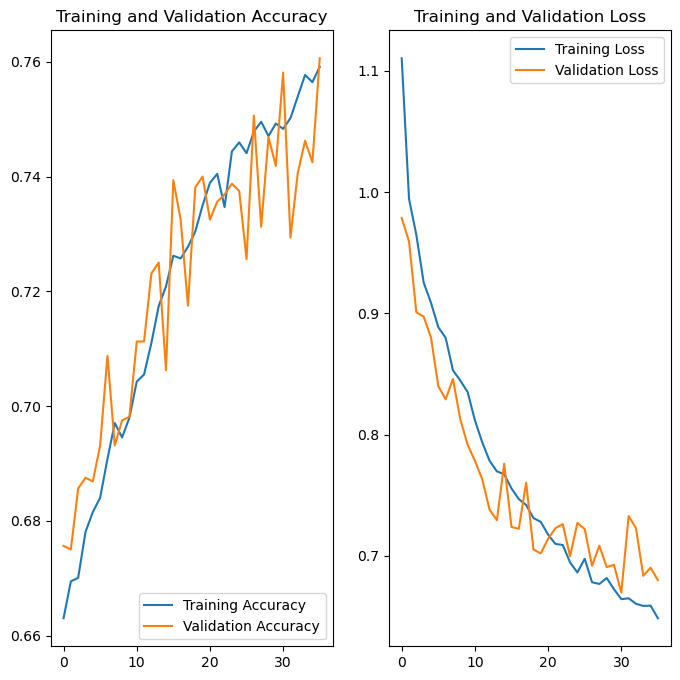

In [128]:
plot_histories(history_1,36)

In [161]:
preds = model_1.predict(test_data,steps = test_data.samples/test_data.batch_size)
y_pred = preds.argmax(axis=1)

ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_7/conv2d_21/Relu' defined at (most recent call last):
    File "c:\Users\nyila\anaconda3\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\nyila\anaconda3\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\nyila\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\nyila\anaconda3\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "c:\Users\nyila\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "c:\Users\nyila\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\nyila\anaconda3\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\nyila\anaconda3\lib\asyncio\base_events.py", line 1906, in _run_once
      handle._run()
    File "c:\Users\nyila\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\nyila\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\nyila\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\nyila\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\nyila\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "c:\Users\nyila\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "c:\Users\nyila\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\nyila\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "c:\Users\nyila\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "c:\Users\nyila\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\nyila\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\nyila\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\nyila\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\nyila\AppData\Local\Temp\ipykernel_8376\3600467701.py", line 1, in <module>
      preds = model_1.predict(test_data,steps = test_data.samples/test_data.batch_size)
    File "c:\Users\nyila\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nyila\anaconda3\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\nyila\anaconda3\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "c:\Users\nyila\anaconda3\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\nyila\anaconda3\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\nyila\anaconda3\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "c:\Users\nyila\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nyila\anaconda3\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\nyila\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nyila\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\nyila\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nyila\anaconda3\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\nyila\anaconda3\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\nyila\anaconda3\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\nyila\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nyila\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\nyila\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nyila\anaconda3\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "c:\Users\nyila\anaconda3\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\nyila\anaconda3\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'sequential_7/conv2d_21/Relu'
OOM when allocating tensor with shape[32,222,222,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_7/conv2d_21/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_141940]

In [ ]:
report = classification_report(name_as_indexes_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.41      0.13      0.20        53
           1       0.55      0.43      0.48       109
           2       0.47      0.41      0.44       218
           3       0.00      0.00      0.00        20
           4       0.57      0.38      0.45       242
           5       0.82      0.94      0.88      1336
           6       0.58      0.72      0.64        25

    accuracy                           0.75      2003
   macro avg       0.49      0.43      0.44      2003
weighted avg       0.72      0.75      0.73      2003



c:\Users\nyila\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nyila\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nyila\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


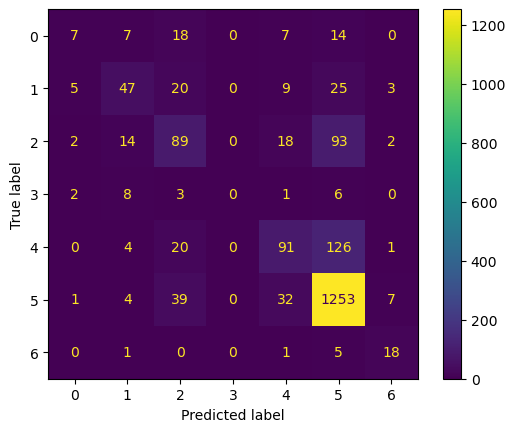

In [ ]:
cm = confusion_matrix(name_as_indexes_test,y_pred)
ConfusionMatrixDisplay(cm).plot()

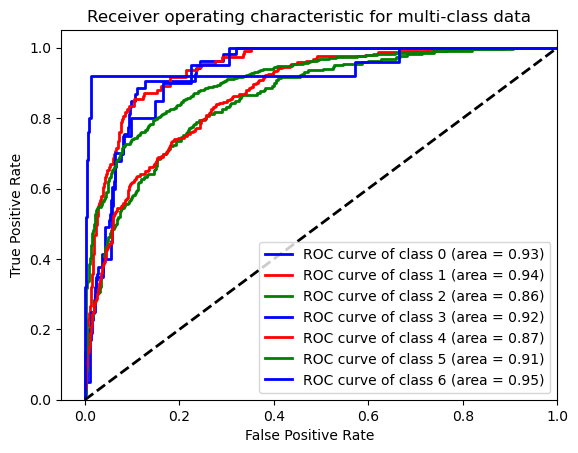

In [ ]:
make_roc_curve(preds)

In [133]:
model_1.save('best_model.keras')

In [16]:
reconstructed_model = tf.keras.models.load_model("best_model.keras")

In [18]:
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

preds = reconstructed_model.predict(test_data,steps = test_data.samples/test_data.batch_size)
y_pred = preds.argmax(axis=1)
report = classification_report(name_as_indexes_test,y_pred)
print(report)

62/62 [==============================] - 11s 171ms/step
              precision    recall  f1-score   support

           0       0.50      0.09      0.16        53
           1       0.56      0.43      0.49       109
           2       0.49      0.42      0.45       218
           3       0.00      0.00      0.00        20
           4       0.59      0.30      0.40       242
           5       0.81      0.95      0.87      1336
           6       0.58      0.76      0.66        25

    accuracy                           0.75      2003
   macro avg       0.50      0.42      0.43      2003
weighted avg       0.72      0.75      0.72      2003



c:\Users\nyila\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nyila\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nyila\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


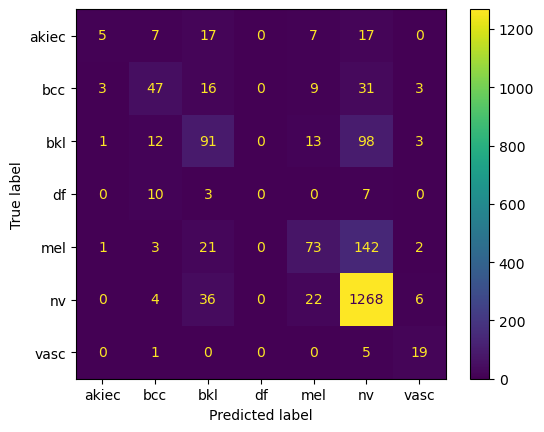

In [23]:
cm = confusion_matrix(name_as_indexes_test,y_pred)
ConfusionMatrixDisplay(cm,display_labels=class_names).plot()

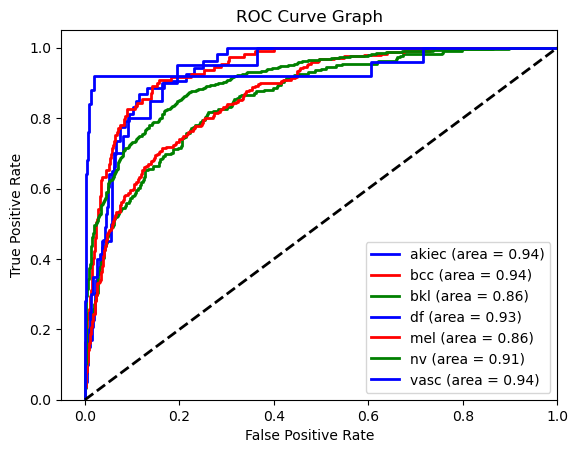

In [34]:
make_roc_curve(preds)

In [35]:
reconstructed_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 15, 15, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 13, 13, 128)       295040    
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 6, 6, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 4, 4, 64)          73792     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 2, 2, 64)        

In [132]:
# Model 2

In [138]:
from keras.preprocessing.image import ImageDataGenerator

data_dir = 'input/all_images/'
batch_size = 32
size=224

train_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range=10,  
                                     zoom_range = 0.1,   
                                     horizontal_flip=True,
                                     shear_range=0.1) 

train_data = train_generator.flow_from_dataframe(dataframe=train,x_col="image_full_name",y_col="dx",
                                                batch_size=32,directory=data_dir,
                                                shuffle=True,class_mode="categorical",target_size=(size,size))

Found 6409 validated image filenames belonging to 7 classes.


In [139]:
test_generator=ImageDataGenerator(rescale = 1./255)

test_data = test_generator.flow_from_dataframe(dataframe=test,x_col="image_full_name",y_col="dx",
                                                batch_size=32,directory=data_dir,
                                                shuffle=False,class_mode="categorical",target_size=(size,size))

val_data = test_generator.flow_from_dataframe(dataframe=val,x_col="image_full_name",y_col="dx",
                                                batch_size=32,directory=data_dir,
                                                shuffle=False,class_mode="categorical",target_size=(size,size))

Found 2003 validated image filenames belonging to 7 classes.
Found 1603 validated image filenames belonging to 7 classes.


In [140]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [157]:
from tensorflow.keras.applications import ResNet50, MobileNetV2, EfficientNetB1

class_names = list(test_data.class_indices)
num_classes = len(class_names)

resnet_base = ResNet50(weights='imagenet',input_shape=(224,224,3))


for layer in resnet_base.layers:
    layer.trainable = False

x = resnet_base.output
x = tf.keras.layers.Dense(32,activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)

predictions = tf.keras.layers.Dense(num_classes, activation='softmax', name='output_layer')(x)
resnet_model = tf.keras.Model(resnet_base.input, predictions)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     metrics=['accuracy'])

In [158]:
resnet_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [159]:
es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

epochs = 25

history_2 = resnet_model.fit_generator(generator=train_data,
                    steps_per_epoch=train_data.samples//train_data.batch_size,
                    validation_data=val_data,
                    verbose=1,
                    callbacks=[es],
                    validation_steps=val_data.samples//val_data.batch_size,
                    epochs=epochs)

C:\Users\nyila\AppData\Local\Temp\ipykernel_8376\407885416.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_2 = resnet_model.fit_generator(generator=train_data,


Epoch 1/25
200/200 [==============================] - 461s 2s/step - loss: 1.5283 - accuracy: 0.6632 - val_loss: 1.1654 - val_accuracy: 0.6756
Epoch 2/25
 17/200 [=>............................] - ETA: 5:45 - loss: 1.1914 - accuracy: 0.6728

KeyboardInterrupt: 

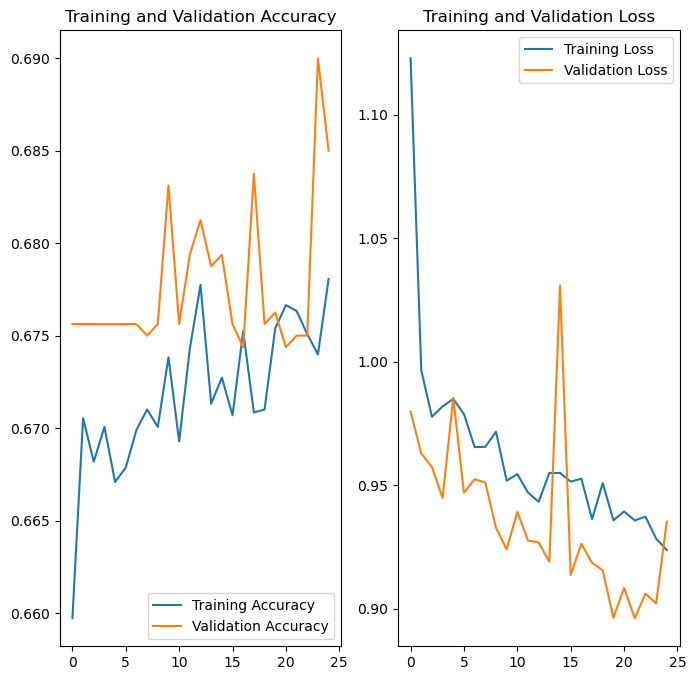

In [119]:
plot_histories(history_2,epochs)

In [120]:
preds = model_2.predict(test_data,steps = test_data.samples/test_data.batch_size)
y_pred = preds.argmax(axis=1)
report = classification_report(name_as_indexes_test,y_pred)
print(report)

62/62 [==============================] - 12s 188ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        53
           1       0.00      0.00      0.00       109
           2       0.33      0.28      0.31       218
           3       0.00      0.00      0.00        20
           4       0.57      0.14      0.23       242
           5       0.73      0.96      0.83      1336
           6       0.00      0.00      0.00        25

    accuracy                           0.69      2003
   macro avg       0.23      0.20      0.19      2003
weighted avg       0.59      0.69      0.61      2003



c:\Users\nyila\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nyila\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nyila\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


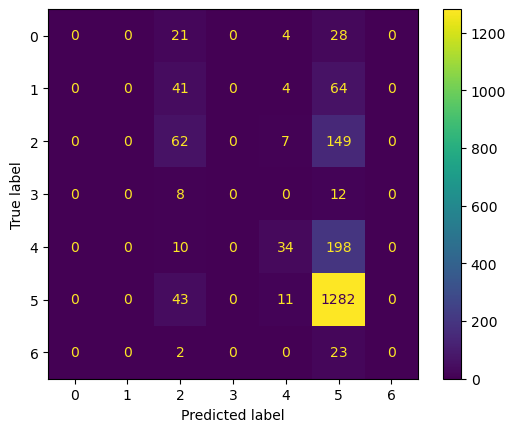

In [121]:
cm = confusion_matrix(name_as_indexes_test,y_pred)
ConfusionMatrixDisplay(cm).plot()

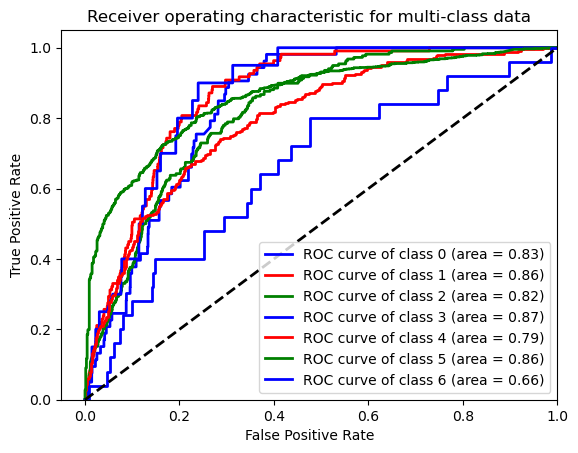

In [122]:
make_roc_curve(preds)